##Debunking Stock Prediction Video

A Somewhat viral video shows how one can predict stock prices by using a simple LSTM Recurrent Neural Network (https://www.youtube.com/watch?v=QIUxPv5PJOY&t=444s). While the video does make a disclaimer that this method should not be used to actually make investment decisions. This file will:
1) Recreate the code in the video with Amazon Stock
2) Demonstrate why this method fails when the user attempts to extrapolate far into the future.
3) Modify the Code to be put into a function to test different learning rates, dataset lengths, etc.

In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
from pandas_datareader import data as pdr
import fix_yahoo_finance




###Theory

The video claims we can use a LSTM to use the previous x days to predict what the value of a stock is the next day. Below is the preprocessing and machine learning architecture

In [26]:
#download data
from google.colab import files
df = list(files.upload().keys())[0]
print(df)
df = pd.read_csv(df)

Saving AMZN 2.csv to AMZN 2 (1).csv
AMZN 2.csv


Visualize Data

Dataframe shape: (5879, 7)


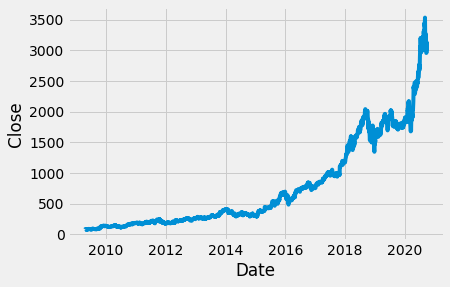

In [27]:
plt.style.use('fivethirtyeight')
plt.figure(1)
plt.xlabel("Date")
plt.ylabel("Close")


df['Date'] = pd.to_datetime(df['Date'])
print("Dataframe shape:", df.shape)

temp = df.loc[3000:5880]

plt.plot(temp['Date'],temp['Close'])


Data Preprocessing

In [28]:
all_feat = temp.filter(['Close']).values


#85% of data will train
train_lim = int(len(all_feat)*.85)+1

#Normalize
from sklearn.preprocessing import MinMaxScaler

all_feat1 = all_feat
scalar = MinMaxScaler(feature_range=(0,1))
all_feat = scalar.fit_transform(all_feat)


#Create Data sets
train_feat = []
train_label = []

days = 60
for x in range(days,train_lim):
  train_feat.append(all_feat[x-days:x, 0])
  train_label.append(all_feat[x, 0])


test_feat = []
test_label= []
for x in range(train_lim + days,len(all_feat)):
  test_feat.append(all_feat[x-days:x])
  test_label.append(all_feat[x])


train_feat = np.array(train_feat)
train_label = np.array(train_label)
test_feat = np.array(test_feat)
test_label = np.array(test_label)

test_feat.shape


(371, 60, 1)

In [29]:
#build model

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50,return_sequences=True,input_shape=(days,1)))
model.add(tf.keras.layers.LSTM(50,return_sequences=False))
model.add(tf.keras.layers.Dense(25))
model.add(tf.keras.layers.Dense(1))

In [30]:
#compile
model.compile(optimizer='adam',loss='mean_squared_error')

In [31]:
#train
model.fit(train_feat,train_label,epochs=1,batch_size=1)


2388/2388 [==============================] - 74s 30ms/step - loss: 4.6442e-04


In [32]:
#Predict and inverse the scale

results = model.predict(test_feat)

results = scalar.inverse_transform(results)
results.shape

(371, 1)

(2000.0, 2900.0)

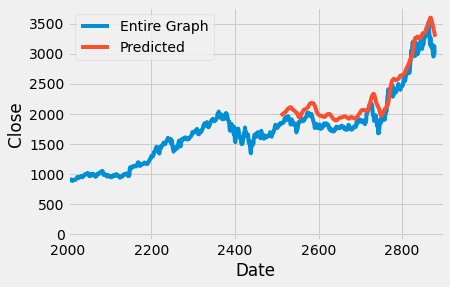

In [33]:
#Plot results
plt.xlabel("Date")
plt.ylabel("Close")
plt.plot(all_feat1,label="Entire Graph")
xs = np.array([x for x in range(2530-20,2901-20)])
xs=xs.reshape(371,1)
plt.plot(xs,results,label="Predicted")
plt.legend()
plt.xlim([2000,2900])



# PART 2: Why This is Innaccurate

While this looks impressive. The issue is that the model needs 60 correct previous inputs and then predicts the value of the 61st day. So, if we were to extrapolate into the future. We would generate partially incorrect values and then use those as "previous inputs" and then make even more partially incorrect predictions. So the inaccuracy magnifies. I have rewritten the code below to pretend that the model does not know what ANY of the actual values are after the 85% mark of the dataset, and will continue generating values and using those to guess the projection of the stock.

In [34]:
results = test_feat[0]

for _ in range(372):
  pred = model.predict(np.array([results[-days:]]))[0]
  #print(results)
  #append the predicted result to the list, that will now be used in the calculation of the next day's value
  results = list(results)
  results.append(pred)
  results = np.array(results)

results = scalar.inverse_transform(results)





(1500.0, 2850.0)

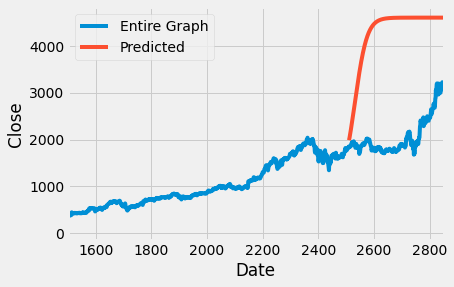

In [35]:
#Plotting
plt.xlabel("Date")
plt.ylabel("Close")
plt.plot(all_feat1,label="Entire Graph")
xs = np.array([x for x in range(2530-20,2901-20)])
xs=xs.reshape(371,1)
plt.plot(xs,results[days+1:],label="Predicted")
plt.legend()
plt.xlim([1500,2850])

#After plotting this, we can see the results are very dissapointing

The code below is a great example as to why the LSTM code works for the "predictions" done in the video. The predictions in the video just predict what the next day value is going to be. However, this means we can just add or subtract a small random number from the previous day's value and have that be the prediction for the next day. Obviously it is going to give an incorrect value but, it will be close to the actual value.

Note: There is no preprocessing. And the only data being used is the day right before.

(2840.0, 2850.0)

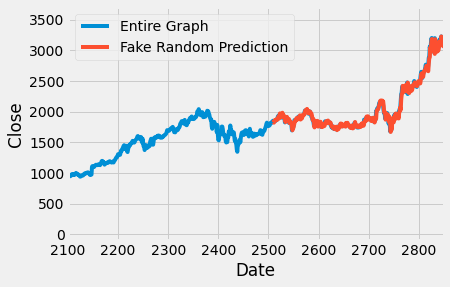

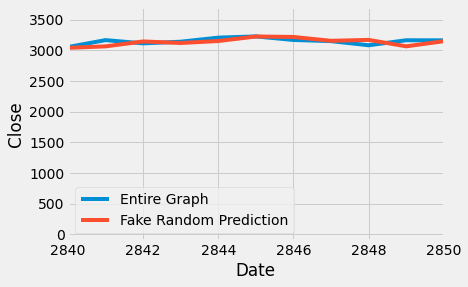

In [36]:
import random as r

xs = []
fakePredict = []

for x in range(train_lim + days,len(all_feat)):
  xs.append(x+1)
  #"predicting" all_feat[x+1] (tommorow's) value by adding a random number 
  fakePredict.append(all_feat1[x] + r.randint(-25,25))
  
plt.figure(1)
plt.xlabel("Date")
plt.ylabel("Close")
plt.plot(all_feat1,label="Entire Graph")
plt.plot(xs,fakePredict,label="Fake Random Prediction")
plt.legend()
plt.xlim([2100,2850])

plt.figure(2)
plt.xlabel("Date")
plt.ylabel("Close")
plt.plot(all_feat1,label="Entire Graph")
plt.plot(xs,fakePredict,label="Fake Random Prediction")
plt.legend()
plt.xlim([2840,2850])

#PART 3: Experimentation

Perhaps there is still hope.

I rewrote the code above as a function for users to specifiy different learning rates, epochs, how many previous days should be used to predict the next day's value,etc.


In [37]:
from sklearn.preprocessing import MinMaxScaler
def compile_train_model(data, daysNeeded, ptrain, lossfunc = 'mean_squared_error', batch_size = 1, epochs = 1, lr = 0.001):
  '''
  Preprocesses data, compiles and trains the LSTM Model.

  :param np.array data: not normalized dataset. Contains stock prices over some arbitrary metric of time
  :param int daysNeeded: number of previous days being used to predict the stock price of the next day
  :param float ptrain: percentage of dataset being used for training
  :param str lossfunc: string name of the loss function (hyperparameter)
  :param int batch_size: batch size hyperparameter for training the model
  :param int epochs: epochs hyperparameter for training the model
  :param float lr: learning rate hyperparameter for training the model
  :return: LSTM model
  "rtype: keras.engine.sequential.Sequential
  '''

  #ptrain% of data will train
  train_lim = int(len(data)*ptrain)+1

  #Normalize
  scalar = MinMaxScaler(feature_range=(0,1))
  scaled_data = scalar.fit_transform(data)


  #Create Data sets
  train_feat = []
  train_label = []

  
  #populate training sets
  for x in range(daysNeeded,train_lim):

    train_feat.append(scaled_data[x-daysNeeded:x, 0])
    train_label.append(scaled_data[x, 0])


  #cast to numpy arrays
  train_feat = np.array(train_feat)
  train_label = np.array(train_label)
  


  #build model
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.LSTM(50,return_sequences=True,input_shape=(daysNeeded,1)))
  model.add(tf.keras.layers.LSTM(50,return_sequences=False))
  model.add(tf.keras.layers.Dense(25))
  model.add(tf.keras.layers.Dense(1))

  #compile
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss=lossfunc)
  
  #train and return

  model.fit(train_feat,train_label,epochs=epochs,batch_size=batch_size)
  print(type(model))
  return model



def runModel(model, data, daysNeeded, ptrain, extrapolate, xlimit= None):
  '''
  Runs the model

  :param keras.engine.sequential.Sequential model: LSTM model making the prediction
  :param np.array data: not normalized dataset. Contains stock prices over some arbitrary metric of time
  :param int daysNeeded: number of previous days being used to predict the stock price of the next day
  :param float ptrain: percentage of dataset being used for training
  :param bool extrapolate: if True, use the model to actual extrapolate the testing data, else do the video's version of "prediction"
  :param list[int] xlimit: list of length 2 that shows the viewing bounds of the x-axis, default is the whole graph
  :return: None
  '''

  #ptrain% of data will train
  data = np.array(data)
  train_lim = int(len(data)*ptrain)+1

  #Normalize
  scalar = MinMaxScaler(feature_range=(0,1))
  scaled_data = scalar.fit_transform(data)
  
  if extrapolate:
    results = np.array(scaled_data[train_lim:train_lim+daysNeeded+1])

    for _ in range(train_lim, len(data)):
      #print(results)
      pred = model.predict(np.array([results[-daysNeeded:]]))[0]
      results = list(results)
      results.append(pred)
      results = np.array(results)

    
  
  else:

    #populate testing sets
    test_feat = []
    #test_label= []
    for x in range(train_lim + daysNeeded,len(data)):
      test_feat.append(scaled_data[x-daysNeeded:x])
      #test_label.append(scaled_data[x])
    test_feat = np.array(test_feat)
    #test_label = np.array(test_label)

    results = model.predict(test_feat)
        

  results = scalar.inverse_transform(results)



  plt.xlabel("Day")
  plt.ylabel("Close")
  plt.plot(data,label="Entire Graph")
  xs = np.array([x+daysNeeded for x in range( train_lim, train_lim+ len(results) )])
  xs=xs.reshape(len(results),1)
  plt.plot(xs[daysNeeded:],results[daysNeeded:],label="Predicted")
  plt.legend()
  if (xlimit): plt.xlim(xlimit)




In [38]:
data = temp.filter(['Close']).values
model = compile_train_model(data, 60, .7)

1956/1956 [==============================] - 60s 29ms/step - loss: 1.3057e-04
<class 'keras.engine.sequential.Sequential'>


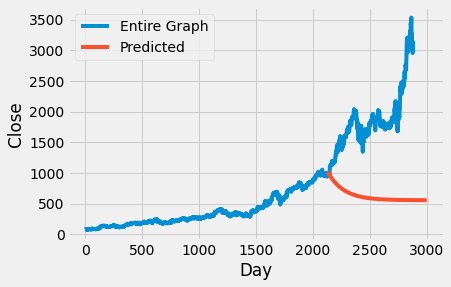

In [39]:
runModel(model,data,60,.7,True)
#still inaccurate

Epoch 1/2
15/15 [==============================] - 7s 173ms/step - loss: 0.0021
Epoch 2/2
15/15 [==============================] - 2s 163ms/step - loss: 1.7628e-04
<class 'keras.engine.sequential.Sequential'>


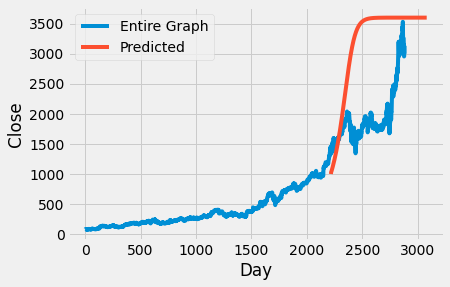

In [40]:
#Some other values
model = compile_train_model(data, 100, .7,lossfunc = 'mean_squared_error', batch_size = 128, epochs = 2, lr = 0.001)
runModel(model,data,100,.7,True)

Epoch 1/50
15/15 [==============================] - 7s 170ms/step - loss: 0.0096
Epoch 2/50
15/15 [==============================] - 3s 184ms/step - loss: 0.0087
Epoch 3/50
15/15 [==============================] - 3s 181ms/step - loss: 0.0078
Epoch 4/50
15/15 [==============================] - 2s 162ms/step - loss: 0.0070
Epoch 5/50
15/15 [==============================] - 2s 161ms/step - loss: 0.0063
Epoch 6/50
15/15 [==============================] - 2s 163ms/step - loss: 0.0056
Epoch 7/50
15/15 [==============================] - 2s 160ms/step - loss: 0.0050
Epoch 8/50
15/15 [==============================] - 2s 163ms/step - loss: 0.0044
Epoch 9/50
15/15 [==============================] - 2s 165ms/step - loss: 0.0039
Epoch 10/50
15/15 [==============================] - 2s 161ms/step - loss: 0.0034
Epoch 11/50
15/15 [==============================] - 2s 164ms/step - loss: 0.0030
Epoch 12/50
15/15 [==============================] - 2s 162ms/step - loss: 0.0026
Epoch 13/50
15/15 [======

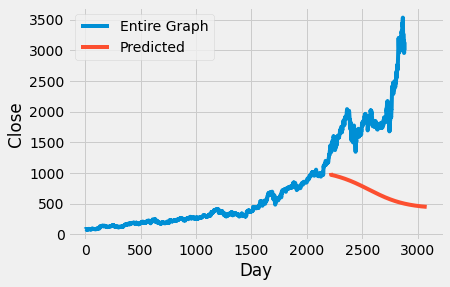

In [43]:
#Some other values
model = compile_train_model(data, 100, .7,lossfunc = 'mean_squared_error', batch_size = 128, epochs = 50, lr = 0.00001)
runModel(model,data,100,.7,True)